In [3]:
import os
import numpy as np
import scipy.io as sio
import glob
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from torchvision.models.vgg import vgg16
from torchvision.models.alexnet import alexnet
import matplotlib.pyplot as plt
from functools import partial

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
image_path = '/content/drive/MyDrive/ACV/Assignment-1/TEST_IMAGES/lena_gray_256_noisy.png'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
transform  = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
def main():

  alex_feature = []
  alex_label = []

  vgg16_feature = []
  vgg16_label = []

  train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

  # test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
  #                                       download=True, transform=transform)


  # [Problem 4 a.] IMPORT VGG16 AND ALEXNET FROM THE MODELS FOLDER WITH
  # PRETRAINED = TRUE


  vgg16_extractor = vgg16(pretrained=True).to(device)
  # vgg16_extractor = vgg16(pretrained=True)
  vgg16_extractor.eval()

  # alex_extractor = alexnet(pretrained=True)
  alex_extractor = alexnet(pretrained=True).to(device)
  alex_extractor.eval()


  for idx, data in enumerate(train_data):
      if idx == 100000:
            break

      image, label = data

      image = image.to(device)

      #Forward pass through VGG16
      with torch.no_grad():
          F_vgg = vgg16_extractor(image.unsqueeze(0))
          vgg16_feature.append(F_vgg.flatten().cpu().numpy())
          vgg16_label.append(label)

      # Forward pass through AlexNet
      with torch.no_grad():
          F_alex = alex_extractor(image.unsqueeze(0))
          alex_feature.append(F_alex.flatten().cpu().numpy())
          alex_label.append(label)


  sio.savemat('vgg16.mat', mdict={'feature': alex_feature, 'label': alex_label})
  sio.savemat('alexnet.mat', mdict={'feature': vgg16_feature, 'label': vgg16_label})

In [9]:
def KNN_test(test_data, K=1):
    # Load the saved .mat files
    vgg_mat = sio.loadmat('vgg16.mat')['feature']
    alex_mat = sio.loadmat('alexnet.mat')['feature']
    alex_labels = sio.loadmat('alexnet.mat')['label'].flatten()

    # Load models and move to GPU if available
    vgg16_extractor = vgg16(pretrained=True).to(device)
    alex_extractor = alexnet(pretrained=True).to(device)

    vgg16_accuracy = 0
    alex_accuracy = 0

    for idx, (data, label) in enumerate(test_data):
        if idx == 300:
            break
        # 1. EXTRACT FEATURES USING THE MODELS - ALEXNET AND VGG16
        data = data.unsqueeze(0).to(device)  # Add batch dimension and move to GPU
        with torch.no_grad():
            F_test_vgg16 = vgg16_extractor(data).flatten().cpu().numpy()
            F_test_alex = alex_extractor(data).flatten().cpu().numpy()

        # 2. FIND NEAREST NEIGHBOR OF THIS FEATURE FROM FEATURES STORED IN ALEXNET.MAT AND VGG16.MAT
        nbrs_vgg = NearestNeighbors(n_neighbors=K, algorithm='ball_tree').fit(vgg_mat)
        distances_vgg, indices_vgg = nbrs_vgg.kneighbors([F_test_vgg16])

        nbrs_alex = NearestNeighbors(n_neighbors=K, algorithm='ball_tree').fit(alex_mat)
        distances_alex, indices_alex = nbrs_alex.kneighbors([F_test_alex])

        # 3. COMPUTE ACCURACY
        # The labels are the K-nearest neighbor labels, not indices, so we need to extract them
        vgg16_nearest_labels = [alex_labels[ind] for ind in indices_vgg[0]]
        alex_nearest_labels = [alex_labels[ind] for ind in indices_alex[0]]

        vgg16_accuracy += accuracy_score([label], vgg16_nearest_labels)
        alex_accuracy += accuracy_score([label], alex_nearest_labels)

    vgg16_accuracy /= len(test_data)
    alex_accuracy /= len(test_data)

    return vgg16_accuracy, alex_accuracy

In [10]:
main()

100%|██████████| 170498071/170498071 [00:03<00:00, 42891661.07it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 148MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. 

In [19]:
test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

# Test using KNN
vgg16_acc, alex_acc = KNN_test(test_data)
print("VGG16 Accuracy:", vgg16_acc)
print("AlexNet Accuracy:", alex_acc)


VGG16 Accuracy: 0.4255
AlexNet Accuracy: 0.5146


In [12]:
# Initializing pretrained models
pretrained_models = {
    'vgg16': models.vgg16(pretrained=True).eval(),
    'alexnet': models.alexnet(pretrained=True).eval()
}

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  w

In [13]:
# Visualizing the activations of different layers
def visualize_activations(activation_data, title):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(activation_data[0][i].cpu().numpy(), cmap='gray')
        ax.axis('off')
    fig.suptitle(title)
    plt.show()


In [14]:
# Function to capture and store activations
def capture_activation(layer_name, model, input, output):
    layer_activations[layer_name] = output.detach()

In [15]:
# Correct path for input image
input_image = Image.open(image_path).convert('RGB')
transformed_image_tensor = transform(input_image).unsqueeze(0)

In [16]:
# Store activation layer
layer_activations = {}

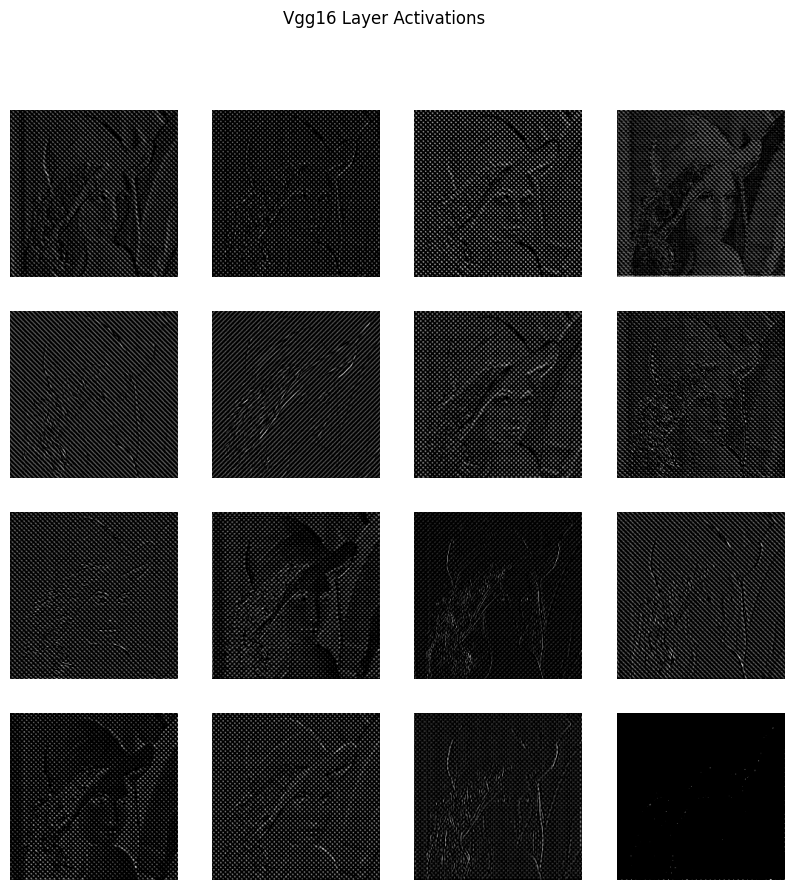

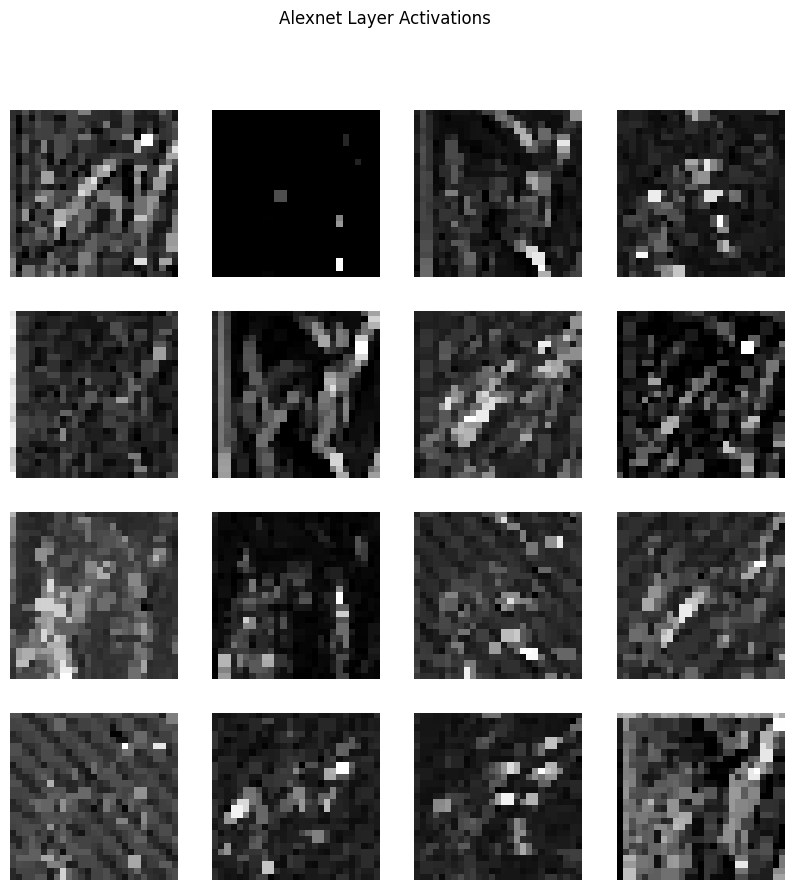

In [17]:
# Register hooks and process the image through models
for model_key, model_instance in pretrained_models.items():
    hook_layer = 2
    model_instance.features[hook_layer].register_forward_hook(
        partial(capture_activation, f'{model_key}_layer_activations')
    )
    _ = model_instance(transformed_image_tensor)
    visualize_activations(
        layer_activations[f'{model_key}_layer_activations'],
        f'{model_key.capitalize()} Layer Activations'
    )